# Identifying and Mitigating Bias in AI

Bias in AI refers to the presence of unfair or prejudiced outcomes produced by artificial intelligence systems due to the underlying data, algorithms or design process. This bias can result in AI systems making decisions or predictions tha systematically favour or disadvantage individuals or groups based on attributes such as race, gender, age, ethnicity, religion, socioeconomic status and more.

There is generally three different ways in which bias in AI systems can emerge:
- **Bias in the data itself**: The data used to train AI models is unrepresentative or contains historical prejudices. These biases or underepresentation can be learnt by the model and perpetuated by the system it is used in.
- **Bias within algorithms**: Algorithms themselves can introduce bias. These can emerge from the mathematical models used or the criteria used to optimise the model.
- **Bias in the overall design of AI systems**: General design choices by developers can introduce bias. The personal beliefs or unconscious biases might influence the design process and, consequently, the behaviour of the AI system. 


Examples of bias in AI systems include:
- Facial recognition systems that misidentify individuals with darker skin tones more often than individuals with lighter skin tones
- Language or image generation models that generate/reinforce sexist or racist comments
- Credit scoring algorithms that discriminate against certain demographics, leading to unequal access to financial services


This notebook provides an example of how bias in AI models can be identified and mitigated.

## Data

In this notebook we will use the COMPAS dataset to demonstrate how bias in models can be identified and how more transparent models without this bias can be trained.

The COMPAS dataset contains information on over 10,000 defendants assessed using the COMPAS tool in Broward County, Florida, between 2013 and 2014. It includes demographic data, criminal history, and details about prior offenses, aiming to predict the likelihood of recidivism. However, concerns have been raised regarding fairness and bias in the COMPAS predictions, as studies have shown disparities across racial and ethnic groups. It therefore provides a good basis for demonstrating how bias in datasets can be identified and mitigated.

The COMPAS data used was obtained from ProPublica at https://github.com/propublica/compas-analysis.

In [80]:
import pandas as pd

# load conpas data and view columns
compas_df = pd.read_csv("compas.csv")

#filter to recidivism only
compas_rec_df = compas_df[compas_df['type_of_assessment'] == "Risk of Recidivism"]

#load person data
person_df = pd.read_csv("person.csv")

#view first rows
pd.set_option('display.max_columns', None)

# Detecting Bias

AI systems can inadvertently perpetuate biases present in the data they are trained on, leading to unfair or discriminatory outcomes. To address this issue, it is essential to actively identify and mitigate bias in AI models.

Fairlearn (https://fairlearn.org/) is an open-source community driven project that helps improve fairness in AI systems. It does this by providing a toolkit that allows users to assess for bias in machine learning models through various metrics and through applying algorithms to trained models to mitigate bias that might be present.

Below we will use Fairlearn to identify bias in the predictions made by COMPAS.

In [81]:
#import necessary libraries
import fairlearn
import sklearn

# create a df to test fairness of predictions
fairness_test_df = person_df[['race', 'decile_score', 'is_recid']]

#filter out rows with unknown recidivism
fairness_test_df = fairness_test_df[fairness_test_df['is_recid'] != -1]

#function to set recidivism prediction based on compas decile score
# 1-5 = not recidivate coded as 0
# 6-10 = recidivate coded as 1

def compas_pred(decile_score):
    if 0 <= decile_score <= 5:
        return 0
    else:
        return 1
    
#apply function
fairness_test_df['compas_pred'] = fairness_test_df.apply(lambda x: compas_pred(x['decile_score']), axis=1)

#drop decile score
fairness_test_df = fairness_test_df.drop('decile_score', axis=1)

#view dataframe
fairness_test_df.head()

,race,is_recid,compas_pred
0,Other,0,0
2,African-American,1,0
3,African-American,1,0
4,African-American,0,1
5,Other,0,0


### Fairness Metrics

Fairness can have different definitions in the context of AI. However generally fairness in AI normally involves removing bias from our models so that the performance for the model is similar across all groups. Not removing bias from models can result in different treatment of groups in a way that undermines our notion of fairness. 

There are several different fairness metrics that can be used to identify if there is different treatment of sub-groups. 

| Fairness Metric     | Description                                                             | When to use                                                                                                                                                                                         |
|---------------------|-------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Demographic parity  | The proportion of positive cases are close for each sub-group.          | Useful for when you want different sub-groups to be equally allocated positive predictions (regardless of the accuracy of those predictions).                                                       |
| Accuracy parity     | The accuracies of each subgroup are close to each other.                | Useful as an overall measure of the consistency of model performance across sub-groups.                                                                                                             |
| Equalised odds      | The true positive and false positive rates are close across all groups. | The fairness concern is with the positive case being assigned accurately as disproportionate harm might occur for incorrect allocation.                                                             |
| Equal opportunity   | The true positive rates are close for each sub-group.                   | The fairness concern is with the positive case being correctly assigned when it is assigned. The unfairness we are concerned with is primarily the harm caused by an incorrect positive prediction. |
| Predictive equality | The false positive rates are close for each sub-group.                  | The fairness concern is specifically with assigning positive predictions  and whether assigning positive predictions could cause harm to a disadvantaged sub-group.                                 |

#### Fairness Metrics in COMPAS

The fairness metrics to use will differ depending on the specific context in which the model is proposed to be applied. Choosing the correct metric(s) will require taking into account which groups will possibly be treated unfairly and the harm that will result from this unfair treatment. 

In the context of COMPAS, we suspect that the African-American group may be unfairly treated by a model that predicts recidivism and the harm we are concerned with from this unfair treatment is incorrect imprisonment or more severe sentencing that might emerge from being incorrectly being labeled a risk of recidivism. 

Given this context, we are concerned with the accuracy of positive predictions as a criterion of fairness meaning we will use the *equalised odds* and *predictive equality* metrics to assess the COMPAS model for fairness.
- The implementation of equalised odds used here will calculate the difference between true positive and false positive rates of different groups and report the largest gap. A higher number reported will represent a larger gap in the accuracy of positive predictions.
- Predictive equality will be examined simply by calculating the false positive rate for each sub-group and reporting the absolute difference between groups 

In [82]:
#import fairlearn fairness assessment libraries
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, false_positive_rate, true_positive_rate,equalized_odds_difference

y_true = fairness_test_df['is_recid']
y_pred = fairness_test_df['compas_pred']
sf_data = fairness_test_df['race']

#common metrics
metrics = {
    'acc' : accuracy_score,
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_true,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_true, y_pred,sensitive_features=sf_data)

#view equalised odds score
print(eq_odds)

0.5224775224775225


An equalised odds score of around 0.5 means that the largest gap in positive prediction performance between two sub-groups is 50%. At a glance, this tells us that the model is not performing across well for positive predictions. The next step is to examine more detailed metrics across all groups to see where the model is failing.

In [83]:
#print metrics
print(metric_frame.by_group)

                       acc       fpr       tpr   count
race                                                  
African-American  0.606799  0.400782  0.618391  5501.0
Asian             0.849057  0.071429  0.545455    53.0
Caucasian         0.698009  0.179919  0.392103  3818.0
Hispanic          0.707631  0.159091  0.325670  1009.0
Native American   0.777778  0.217391  0.769231    36.0
Other             0.731079  0.109208  0.246753   621.0


This more detailed view shows us the ways in which the COMPAS predictions exhibit bias. 

The disparity between groups in true positive rates shows how the **equalised odds** metric was produced. The true positive rates for 'Other' and 'Native American' are 0.24 and 0.76 respectively, a difference of 0.52. While there are other varying differences in error rates between groups, only the highest difference was reported.


To produce our **predictive equality** metric we can compare false positive rates between groups. We can see that the COMPAS predictions have a high false positive rate for African-Americans compared to other groups (0.4 for African-Ameicans, with the next closest group at 0.21, half the false positive rate). The smallest false positive rate is 0.07 for the Asian sub-group which produces an overall predictive equality difference of 0.33.

Whether differences of the above 

#### Other ways of reporting fairness metrics
The approach taken here was to report fairness metrics as the largest difference in error rates between groups. There are other a couple of considerations for other approaches that could have been taken.

>
>Difference between one group against many 
>
>We could compare the difference between the African-American group and all other groups combined. This approach would not involve a comparison across all groups but just between a 'unprivileged' group and all other groups combined.
>

>Standardised comparison 
>
> We could divide the error rate for one group by the error rate for the privileged group to produce a ratio. This ratio would tell us how well the model performs for each sub-group in comparison to the privileged group. If comparative model performance is below a defined threshold then we could consider that reason for intervention.



Finally, Fairlearn supports some basic plotting for visualising the metrics generated. Below the false positive rates for the false positive rate across sub-groups.

array([[<Axes: title={'center': 'fpr'}, xlabel='race'>]], dtype=object)

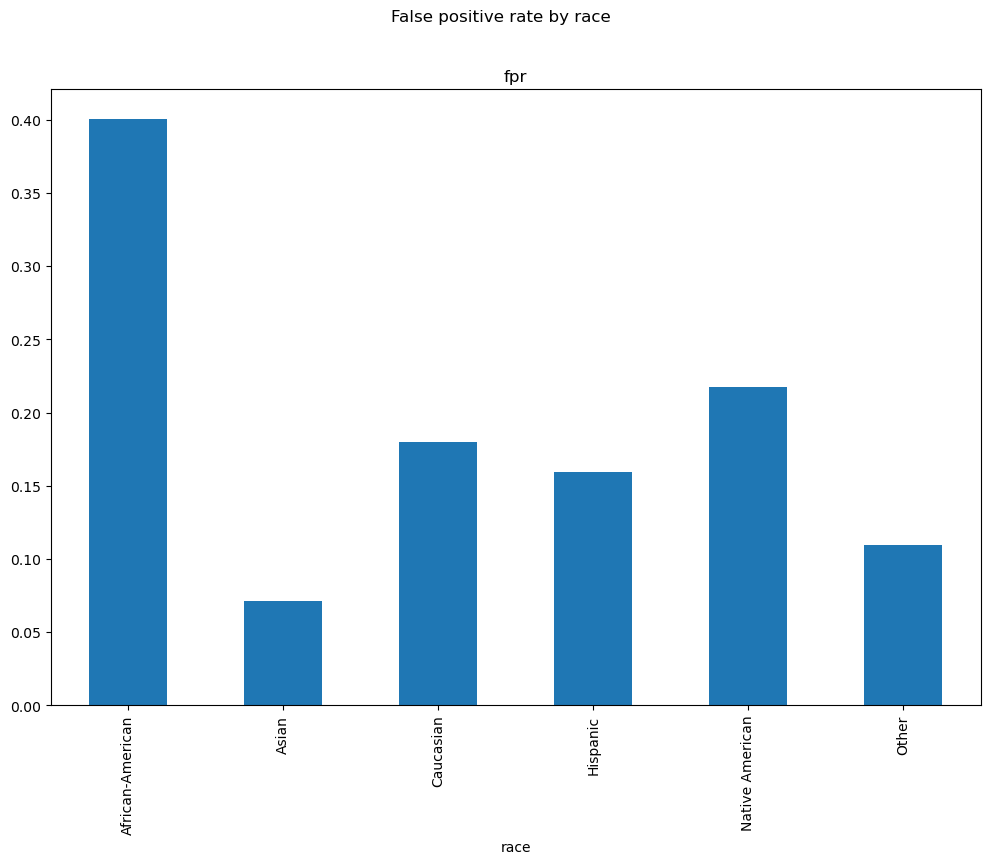

In [84]:
#visualise the false positive rate by race
#barplot of false positive rate
metric_frame.by_group[["fpr"]].plot(
    kind="bar",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="False positive rate by race",
)

# Mitigating Bias

There are three different stages of model development where we can mitigate bias:
- ***Pre-processing***: Manipulating the data we use to train a model to remove bias before it is fed into model training
- ***In-processing***: Bias mitigation techniques applied to model training
- ***Post-processing***: Bias mitigation techniques after the model has been trained

The table below provides an overview of some bias mitigation techniques that can be applied at each stage.

| Stage           | Technique              | Description                                                                                                                                                                                                                                                                                                                        |
|-----------------|------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Preprocessing   | Correlation removal    | Removes correlation between sensitive and other features. This can remove bias against unprivileged groups that can be embedeed in other attributes.                                                                                                                                                                               |
| Preprocessing   | Resampling             | Under and/or oversampling in order to increase/decrease representation of sub-groups in the dataset so that error rates are improved                                                                                                                                                                                               |
| Preprocessing   | Reweighting            | Produce observation weights that can be passed through to a modelling method that accepts weights. This creates a new weighting variable that can be used as an input to model training.                                                                                                                                           |
| In-Processing   | Gridsearch             | Test multiple model parameters to find the ones that best balance accuracy and fairness.                                                                                                                                                                                                                                           |
| In-processing   | Unawareness            | Remove sensitive features from the model. Care should be taken with this approach as bias could be embedded in other features which could also require removal.                                                                                                                                                                    |
| In-processing   | Adverserial debiasing  | Learns a classifier that maximises prediction accuracy and simultaneously reduces an adversary’s ability to determine the protected attribute from the predictions. This creates a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.                            |
| Post-processing | Threshold optimisation | Involves adjusting the decision threshold of a binary classifier per group to achieve the desired fairness outcome. Great care should be taken with this technique as it can increase individual unfairness in that two individuals that are equal except for the sub-group they belong to will be explicitly treated differently. |

The bias mitigation techniques will depend on the specific circumstances of our case however it will normally be the case that only one or two mitigation techniques will be best to apply. This is because the effects of mitigation often do not compound and the more mitigation techniques we apply to more difficult it will be to understand the model produced.

***Mitigating bias in COMPAS***
</br>
We are not able to mitigate bias in the COMPAS model itself as we don't have access, however we will train a new model to predict recidivism based on the publicly available COMPAS data and mitigate bias within that model.

### Training a new model

To train a new model, we will use InterpretML (https://interpret.ml/). InterpretML is a toolkit that enables training models that are more interpretable and explainable. 
One of the key features of responsible AI is that AI systems should be transparent. Transparency is in large part achieved by developing AI models that are interpretable and explainable.

>***Interpretable AI*** is AI where humans can understand the decision-making process of an AI system. Specifically, this is about how well the inner workings of an AI system be can understood by a human.
>
>***Explainable AI*** refers to the ability of an AI system to provide clear and understandable justification for its decisions. Specificially the system should be able to provide a clear and transparent explanation for why it made a particular decision.


We will use InterpretML to train a model to predict recidivism based on the COMPAS data.

In [85]:
#identify the columns from the COMPAS data that will be kept and used for training
keep_cols = ['sex', 'race', 'age', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'is_recid']
train_df = person_df[keep_cols]

#filter out rows with unknown recidivism outcome
train_df = train_df[train_df['is_recid'] != -1]

#change Asian and Native maerican to other category as numbers too small to reliable train and test
train_df['race'].mask(train_df['race'] == 'Asian', 'Other', inplace=True)
train_df['race'].mask(train_df['race'] == 'Native American', 'Other', inplace=True)

#remove rows with missing values
train_df = train_df.dropna()

#view data that will be used to train the model
train_df.head()

,sex,race,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,is_recid
0,Male,Other,69,Greater than 45,0,0,0,0,(F3),Aggravated Assault w/Firearm,0
2,Male,African-American,34,25 - 45,0,0,0,0,(F3),Felony Battery w/Prior Convict,1
3,Male,African-American,24,Less than 25,0,0,1,4,(F3),Possession of Cocaine,1
4,Male,African-American,23,Less than 25,0,1,0,1,(F3),Possession of Cannabis,0
5,Male,Other,43,25 - 45,0,0,0,2,(F7),arrest case no charge,0


In [86]:
#import libraries for model training
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#create train/test split
train, test = train_test_split(train_df, test_size=0.2, random_state=42)

x_train = train.loc[:, train.columns != 'is_recid']
y_train = train.loc[:, train.columns == 'is_recid']

x_test = test.loc[:, test.columns != 'is_recid']
y_test = test.loc[:, test.columns == 'is_recid']

#### Explainable Boosting Machine (EBM)

EBM is an example of a ***glassbox model*** and is what we will use to train a more transparent model

>***Glassbox models*** are designed for explainability, meaning that the model can clearly explain how it made its predictions. This is in contrast to ***blackbox models*** where explanations are not direct.

EBM is an additive, tree-based model that uses gradient boosting with an ensemble of decision trees. EBM models have high accuracy and allow effective visualisation of how a model makes its predictions due to their additive nature. Due to this they are very popular for training AI models that promote transparency.

In [87]:
#train a explainable boosting classifier
ebm = ExplainableBoostingClassifier()
ebm.fit(x_train, y_train)

#model performance
y_pred = ebm.predict(x_test)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7184377838328792
Precision: 0.6882481376148737
Recall: 0.6313502376827047
F1 Score: 0.6375986009783383


The model performs modestly well with all metrics ranging between 0.60 and 0.70.


InterpretML provides both ***global*** and ***local*** visualisations that make model explanations accessible to people. ***Global*** visualisation shows which features are most important for making a prediction while ***local*** visualisation shows how the model arrived at an individual prediction. 

The visualisation below is provided by InterpretML and will show the overall contribution of each variable to how the model predicts its outcomes and detail on how each individual attribute contributes to the model's predictions.

In [88]:
from interpret import show

#explain the overall model
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2240410093216/ -->

From the ***global** explanation provided, we can see that:
- Priors count, age, type of charge and race are the top predictors of whether an individual will recidivate
- The higher the priors are, the more likely it is someone will recidivate. However interestingly fewer than 2 priors is associated with a lower likelihood to recidivate.
- Younger ages are associated with a higher likelihood to recidivate. Those below 30 have an increased probability for recidivating while those above 30 have a decreased likelihood to recidivate.
- Being female will reduce the probability scoring of the predictor while being male will result in a very slightly increased likelihood.
- All races except for African-American are associated with a lower likelihood to recidivate, African-Americans will receive a higher score when predicting recidivism

Next we can examine the ***local*** explanations.

In [89]:
#explain individual predictions
ebm_local = ebm.explain_local(x_test, y_test)
show(ebm_local)

<!-- http://127.0.0.1:7001/2240387383056/ -->

The local explainer shows what the model predicted for each case, the probability associated with that prediction and how each feature impacted that prediction. This provides an extremely useful explanation for human users of that prediction. 

For example, examining the first prediction (prediction 0) reveals that:
- The prediction was wrong with a high level of confidence. The model predicted that the person would not recidivate with a confidence of 0.884, the person did recidivate.
- The largest contributors that led to this high level of confidence were the fact that the individual did not have any priors, was older and female and was caucasian.
- The interaction variable race and age slightly increase the likelihood of recidivating in this case. This demonstrates that while age and race are individually leading to a lower prediction, the interaction is capturing the nuance that being both older and caucasian actually presents a higher probability of recidivating.

#### Assessing Bias 

A bias assessment of the newly trained model will focus on what we assessed with COMPAS above: race will be the sensitive feature and equalised odds and predictive parity will be the metrics used for assessment.

In [90]:
#define sensitive feature
sf_data = x_test['race']

#common metrics
metrics = {
    'acc' : accuracy_score, 
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

In [91]:
eq_odds

0.33571428571428574

An equalised odds score of 0.33 shows a disparity of model performance across sub-groups. Examining the true and false positive rates in detail will reveal where this is occurring.

In [92]:
metric_frame.by_group

,acc,fpr,tpr,count
race,,,,
African-American,0.676018,0.180000,0.470330,1105.0
Caucasian,0.755236,0.047703,0.191919,764.0
Hispanic,0.752577,0.021127,0.134615,194.0
Other,0.805755,0.056604,0.363636,139.0


There are significant disparities across groups for both false positive and true positive rates. Most notably for our fairness assessment here is that African-Americans have the highest false positive rate, meaning that they are more likely to be incorrectly judged recidivist. The differences in false positive rates here does provide reason to utilise some of our bias mitigation techniques to increase the fairness of our model. 

### Mitigating Bias

As outlined above, there are several techniques that can be used to mitigate bias in models. We will apply two such techniques here:
- Unawareness
- Threshold optimisation

#### Unawareness

The first technique we will apply will be unawareness, this will involve simply removing the sesitive feature (in this case race) from the dataset.

In [93]:
#get race variable
test_race = x_test['race']
x_train_u = x_train.drop(['race'], axis=1)
x_test_u = x_test.drop(['race'], axis=1)

#train a explainable boosting classifier
ebm_u = ExplainableBoostingClassifier()
ebm_u.fit(x_train_u, y_train)

#model performance
y_pred = ebm_u.predict(x_test_u)

# Assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7175295186194369
Precision: 0.6893146503884573
Recall: 0.6262994802079168
F1 Score: 0.6314900175101191


In [94]:
#common metrics
metrics = {
    'acc' : accuracy_score, 
    'fpr' : false_positive_rate,
    'tpr' : true_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = test_race
)


#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

print(eq_odds)

0.2598901098901099


In [95]:
metric_frame.by_group

,acc,fpr,tpr,count
race,,,,
African-American,0.677828,0.150769,0.432967,1105.0
Caucasian,0.755236,0.056537,0.217172,764.0
Hispanic,0.742268,0.049296,0.173077,194.0
Other,0.791367,0.047170,0.272727,139.0


#### Threshold Optimisation

Threshold optimisation will take the trained EBM model and the sensitive feature (in this case race) and produce a transformation of the model's prediction to enforce the parity constraint provided. The parity constraint is enforced by applying different classification thresholds to different classes within the sensitive feature. So in our instance African-American may have a higher probability threshold to be classified as a recidivist while Asian may a lower threshold for being classified as recidivist.

In [96]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer

#create optimiser
postprocess_est = ThresholdOptimizer(
                    estimator=ebm,
                    constraints="false_positive_rate_parity",
                    prefit=True,
                    predict_method="predict_proba"
)

#define sensitive feature for training
sensitive_features = x_train['race']

#train model with fairness constraint
fair_ebm = postprocess_est.fit(x_train, y_train, sensitive_features=sensitive_features)


#define sensitive feature for predictions
sensitive_features = x_test['race']

#make predictions with updated model
y_pred = fair_ebm.predict(x_test, sensitive_features=sensitive_features)

#assess the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7125340599455041
Precision: 0.6867206376006019
Recall: 0.6127993247145587
F1 Score: 0.6143664252951252


In [97]:
#define sensitive features
sf_data = x_test['race']

#common metrics
metrics = {
    'acc' : accuracy_score,
    'fpr' : false_positive_rate,
    'count' : count
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true = y_test,
    y_pred = y_pred,
    sensitive_features = sf_data
)

#equalised odds
eq_odds = equalized_odds_difference(y_test, y_pred,sensitive_features=sf_data)

print(eq_odds)

0.2676767676767676


In [98]:
#view metrics
metric_frame.by_group

,acc,fpr,count
race,,,
African-American,0.656109,0.101538,1105.0
Caucasian,0.763089,0.067138,764.0
Hispanic,0.762887,0.063380,194.0
Other,0.812950,0.103774,139.0


Fairlearn also provides the ability to visualise the decision the tradeoff that has been made through optimisation. 

The plot below shows that a choice for a lower false positive rates across all groups was chosen at the cost of overall accuracy across all groups. In the context of COMPAS this would mean that fewer people would be incorrectly judged as likely to recidivate but that there would be more people who are likely to recidivate that were incorrectly judged likely not to. This highlights the potential trade-off that may be required when mitigating bias.

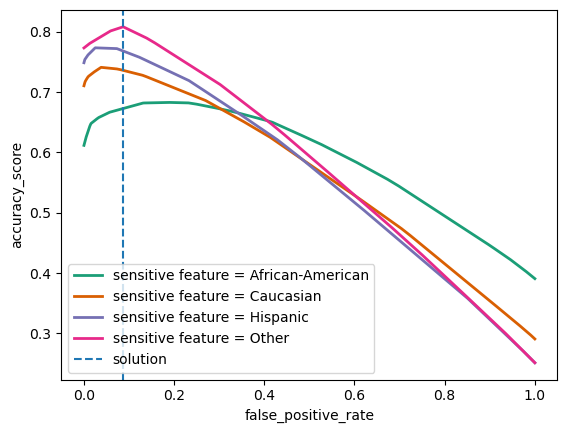

In [99]:
plot_threshold_optimizer(fair_ebm)

# Summary

The table below provides a summary of the performance of the base model and the two bias mitigation techniques applied.

| Model                  | Accuracy | Equalised Odds | False Positive Disparity |
|------------------------|----------|----------------|--------------------------|
| Base                   | 0.72     | 0.34           | 0.16                     |
| Unawareness            | 0.72     | 0.26           | 0.10                     |
| Threshold Optimisation | 0.71     | 0.28           | 0.03                     |

As can be seen, applying bias mitigation techniques improves the fairness of the model. Both the equalised odds and false positive disparity rates are reduced with the mitigation techniques applied without an accuracy trade-off.